In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
path1 = '../Results/Embedding_models/BERT/history_HDFS_GRU_40_model_without_lambda_less_data_benchmark_Adam.csv'
path2 = '../Results/Embedding_models/BERT/history_HDFS_GRU_40_model_without_lambda_less_data_benchmark_SGD.csv'
path3 = '../Results/Embedding_models/BERT/history_HDFS_GRU_40_model_without_lambda_less_data_smart_Adam.csv'
path4 = '../Results/Embedding_models/BERT/history_HDFS_GRU_40_model_without_lambda_less_data_smart_SGD.csv'

history1_df = pd.read_csv(path1)
history2_df = pd.read_csv(path2)
history3_df = pd.read_csv(path3)
history4_df = pd.read_csv(path4)

history1_df = history1_df.reset_index(drop=True)
history2_df = history2_df.reset_index(drop=True)
history3_df = history3_df.reset_index(drop=True)
history4_df = history4_df.reset_index(drop=True)

In [8]:
#plt.plot(df.index, df['a'], marker='o')
history3_df.head(13)

,accuracy,loss,precision_4,recall_4,val_accuracy,val_loss,val_precision_4,val_recall_4
0,0.790429,0.247752,0.950448,0.976605,0.971154,0.030852,1.000000,0.999054
1,0.980198,0.020308,0.999774,0.998022,0.992308,0.012072,1.000000,0.998919
2,0.985148,0.019238,0.998812,0.998079,0.986538,0.014290,1.000000,0.997839
3,0.986799,0.014722,0.999660,0.997909,0.990385,0.008805,1.000000,0.998514
4,0.820132,1.619561,0.819097,0.997627,0.782692,2.188592,0.760543,0.998784
5,0.958746,0.300109,0.961987,0.996779,0.998077,0.007219,1.000000,0.998514
6,0.992574,0.027433,0.998584,0.996383,0.996154,0.007640,1.000000,0.998514
7,0.992574,0.014846,0.999660,0.997627,0.998077,0.013192,1.000000,0.998514
8,0.994224,0.028032,0.997909,0.997740,0.996154,0.010191,0.999730,0.998514
9,0.997525,0.022883,0.998078,0.997909,0.994231,0.049352,0.994618,0.998514


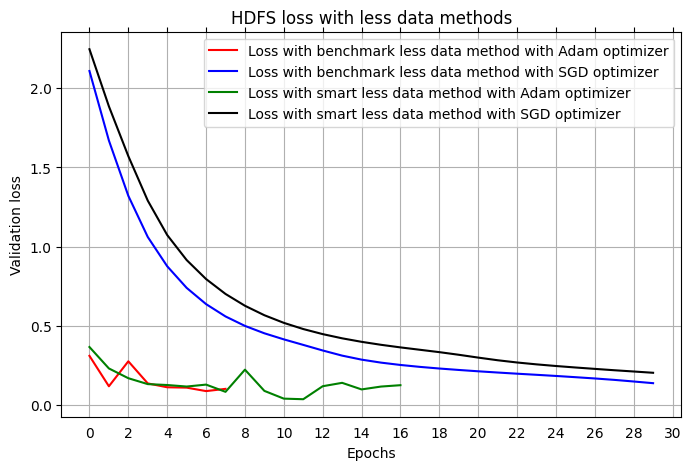

In [11]:
title = 'HDFS loss with less data methods'

plt.figure(figsize=(8, 5))  # Set figure size (width, height) in inches
plt.plot(history1_df.index, history1_df['loss'], color = 'red', label = 'Loss with benchmark less data method with Adam optimizer')
plt.plot(history2_df.index, history2_df['loss'], color = 'blue', label = 'Loss with benchmark less data method with SGD optimizer')
plt.plot(history3_df.index, history3_df['loss'], color = 'green', label = 'Loss with smart less data method with Adam optimizer')
plt.plot(history4_df.index, history4_df['loss'], color = 'black', label = 'Loss with smart less data method with SGD optimizer')

plt.xlabel('Epochs')  # Adjust the x-axis title
plt.ylabel('Validation loss')  # Adjust the y-axis title

plt.title(title)  # Adjust the plot title


# Add a legend
plt.legend(loc='upper right')

# Add gridlines
plt.grid(True)
#plt.xlim([0,50])
#plt.axvline(x=13, color='black', linestyle='--')
x_min = 0
x_max = 30
plt.xticks(np.arange(np.floor(x_min), np.ceil(x_max)+1, 2))

plt.tick_params(axis='both', which='both', bottom=False, top=True, left=True, right=False, labelbottom=True, labelleft=True)
# Display the plot
#plt.xlim([0,500])
plt.savefig('../Figures/less_data_models/less_data_comparison_BERT_loss.png', dpi=300, bbox_inches='tight')  # Save the plot

plt.show()

In [12]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest




import ast
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import Dense
from tensorflow.keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from keras.models import Sequential
from autoencoder_module import AutoEncoder
from Data import train_test_split_count_matrix_baseline, count_matrix #, train_test_split_count_matrix_for_LSTM_easier_padding, train_test_split_count_matrix_for_LSTM, create_arrays_from_df_easier_v1
import h5py
from Analysis import roc_curve_for_analysis
from math import ceil
from typing import Tuple
from tensorflow.keras.layers import Dense, GRU, Lambda, Flatten
import tensorflow.keras as keras

def sequence_for_embedding(event_list, n, length_of_sequence: int=50) -> np.array:
    sequence = []
    i = 0
    for event in event_list:
        sequence.append(int(event[1:]) - 1)
    if len(sequence) < length_of_sequence:
        for i in range(length_of_sequence-len(sequence)):
            sequence.append(n)
        return np.array(sequence)
    else:
        return np.array(sequence[0:length_of_sequence])

def create_arrays_from_sequences(data_df:pd.DataFrame) -> Tuple[np.array, np.array]:
    X, y = [], []
    for _, row in data_df.iterrows():
        seq = row['Event_sequences']
        label = row['label']
        X.append(seq)
        y.append(label)
    return X, y

def create_sequences_for_embedding(path: str, length_of_sequences: int, test_size: float=0.2, BGL: bool=False, random_state: int=42):
    #Loading in the data
    data_df = pd.read_csv(path)
    if BGL:
        data_df.drop(columns='new label', inplace = True)
    #Converting the labels to binary numbers, 0 for success, 1 for failure
    mask = data_df['Final Label'] == 'Success'
    data_df.loc[mask, 'label'] = 0
    data_df.loc[~mask, 'label'] = 1
    #I do not need the index column
    data_df = data_df.reset_index(drop=True)

    data_df['Events']  = data_df['New Event ID'].apply(ast.literal_eval)
    #Calculating the maximum value of the En type events
    max_n = max(int(e[1:]) for sublist in data_df['Events'] for e in sublist)
    data_df['Event_sequences'] = data_df['Events'].apply(lambda x: sequence_for_embedding(x, max_n, length_of_sequences))
    data_df.drop(columns=['Unnamed: 0', 'BlockId', 'New Event ID', 'Final Label', 'Events'], inplace=True)
    #Separate the dataframes based on the label and perform the train_test_split
    success_df = data_df.loc[data_df['label'] == 0].copy(deep=True)
    fail_df = data_df.loc[data_df['label'] == 1].copy(deep=True)
    train_success_df, test_success_df = train_test_split(success_df, test_size=test_size, shuffle=True, random_state=random_state)
    train_fail_df, test_fail_df = train_test_split(fail_df, test_size=test_size, shuffle=True, random_state=random_state)
    #Now concatenate the dataframes
    train_df = pd.concat([train_success_df, train_fail_df], ignore_index=True)
    test_df = pd.concat([test_success_df, test_fail_df], ignore_index=True)
    X_train, y_train = create_arrays_from_sequences(train_df)
    X_test, y_test = create_arrays_from_sequences(test_df)
    return X_train, X_test, y_train, y_test

In [13]:
path = '../Data/BGL/Processed_data/processed_labeled_data.csv'
length_of_matrices = 300
X_train, X_test, y_train, y_test = create_sequences_for_embedding(path, length_of_matrices, BGL=True)

In [16]:
X_test[-1]

array([  2,  31,  17,  31,  17,  31,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,  10,   2,   2,   2, 151, 151, 151,   2,   2,   2,
         2, 151, 151,   2,   2, 151, 151,   2,   2, 151, 151, 151, 151,
       151, 151, 151, 464, 465, 464, 465, 474, 474, 474, 474, 474, 474,
       474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474,
       474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474,
       474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474,
       474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474,
       474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474,
       474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474,
       474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474,
       474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474,
       474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474,
       474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 47

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, TimeDistributed, GlobalAveragePooling1D, Flatten, Lambda, Embedding
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Model
from keras.layers import Lambda, Flatten, Input
from tensorflow.math import reduce_max, reduce_mean
from tensorflow.keras.metrics import Precision, Recall

length_of_matrices = 300
vocabulary_size = 474
embedding_dim = 384
input_layer = Input(shape=(300,))
weights_df = pd.read_csv('../Data/BGL/Processed_data/log_templates_embeddings_BERT.csv')
weights = weights_df.loc[:, '0':'383'].values.astype(np.float32)
padding_vector = np.ones((1, weights.shape[1]), dtype=np.float32) * 0.0525 #Should be 0.1 for HDFS with BERT, 0.0525 for BGL
weights_with_padding = np.vstack([weights, padding_vector])

embedding_layer = Embedding(input_dim=vocabulary_size+1, output_dim=embedding_dim, weights=[weights_with_padding], trainable=False)
embedded_sequences = embedding_layer(input_layer)
gru = GRU(40, return_sequences=True, activation='tanh', kernel_regularizer=l2(0.01))(embedded_sequences) #regularizer 0.01 for BGL
timedistributed = TimeDistributed(Dense(1, activation='sigmoid'))(gru)
flatten=Flatten()(timedistributed)
  #max_val = Lambda(lambda x: reduce_max(x, axis=1))(flatten)
  #mean_val = Lambda(lambda x: reduce_mean(x, axis=1))(flatten)
  #difference_layer = Lambda(lambda x: tf.minimum(2*(x[0] - x[1]),1))([max_val, mean_val]) #2.5 necessary for BGL
model = Model(inputs=input_layer, outputs=flatten)
model.load_weights('../Models/Embedding_models/BERT/BGL_GRU_40_model_with25total.keras')

model.summary()
sample = np.expand_dims(X_test[-1], axis=0)
result = model.predict(sample)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 300, 384)       │       182,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 300, 40)        │        51,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 300, 1)         │            41 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 300)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 233,561 (912.35 KB)

 Trainable params: 51,161 (199.85 KB)

 Non-trainable params: 182,400 (712.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


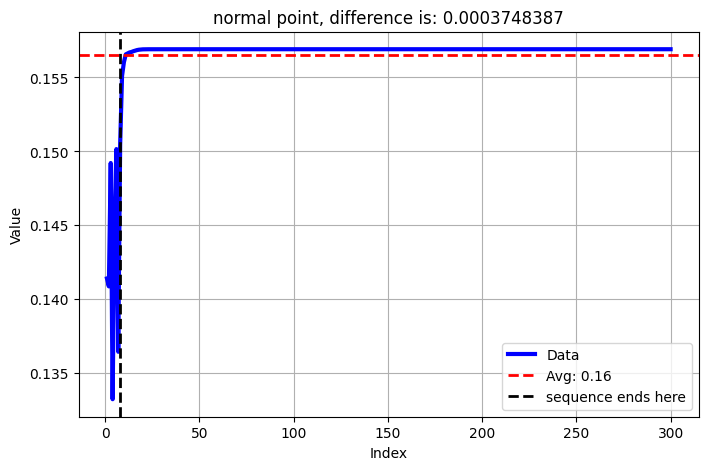

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


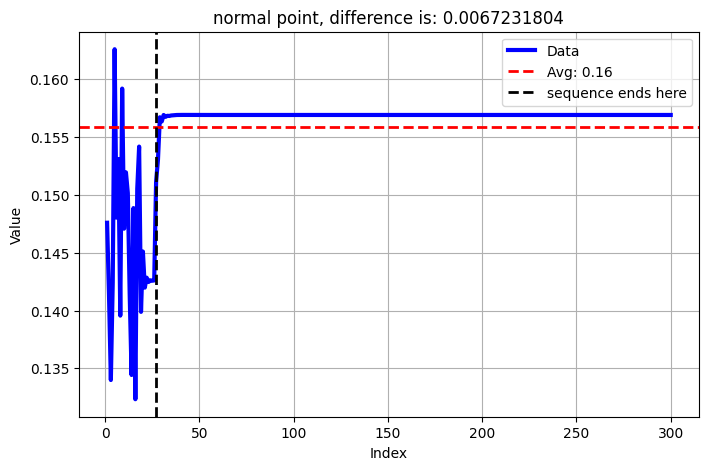

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


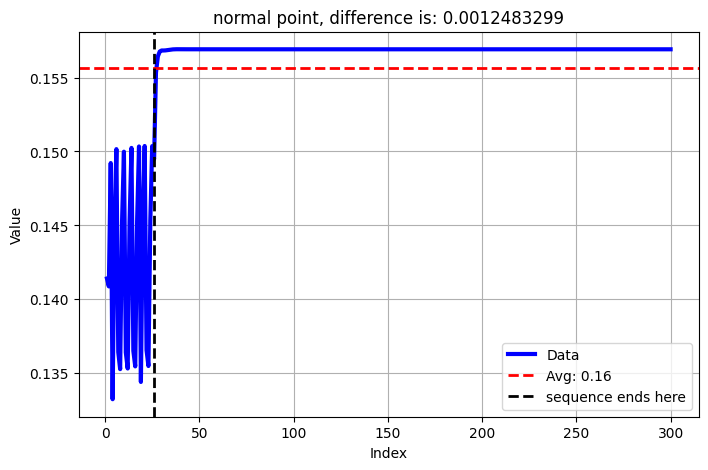

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


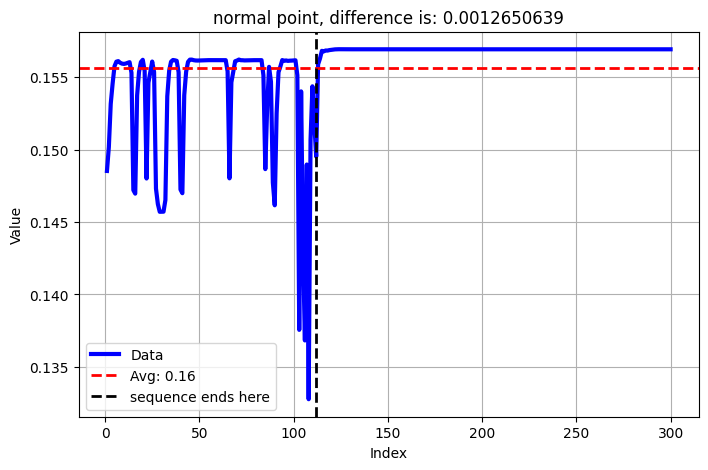

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


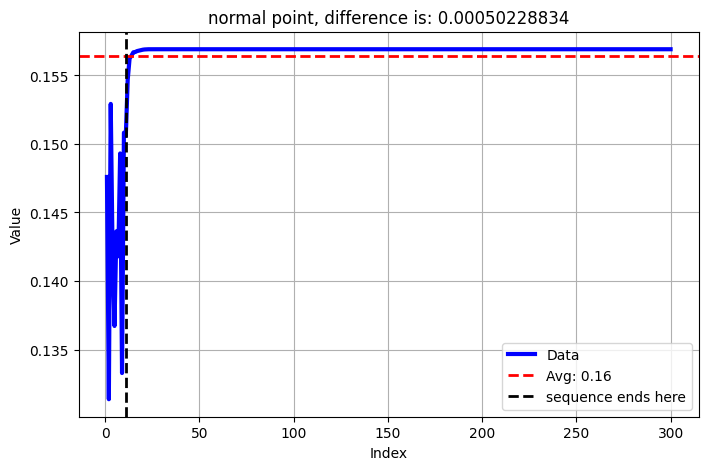

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


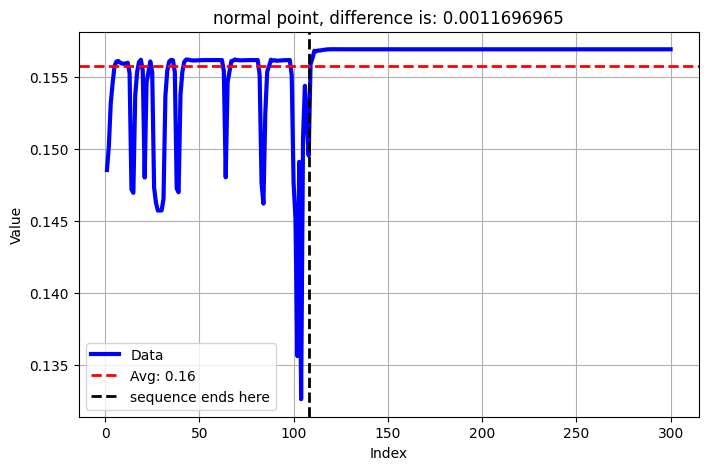

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


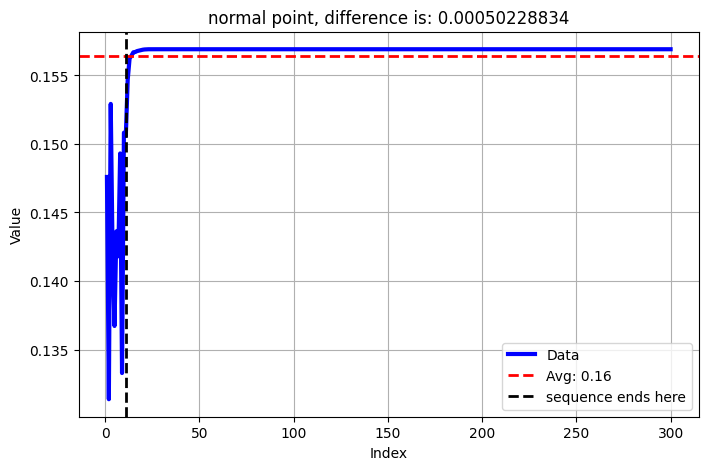

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


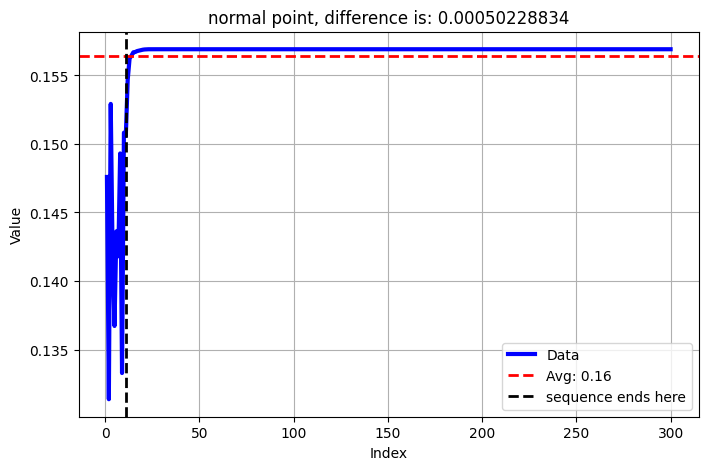

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


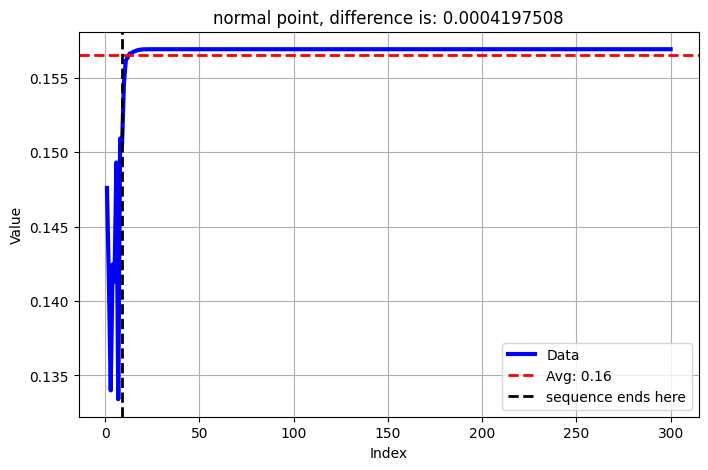

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


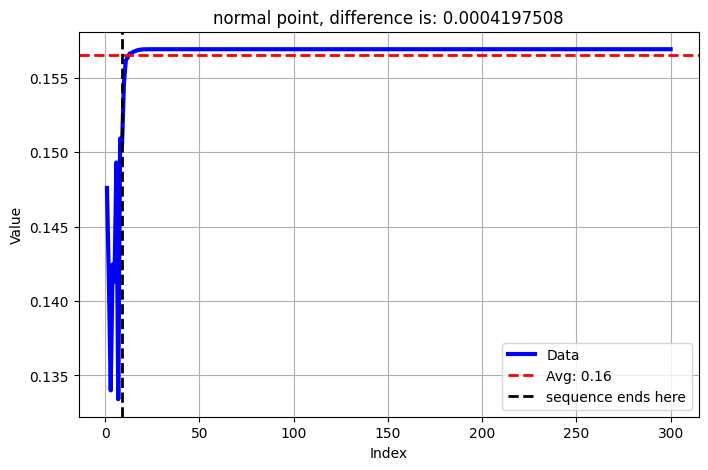

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


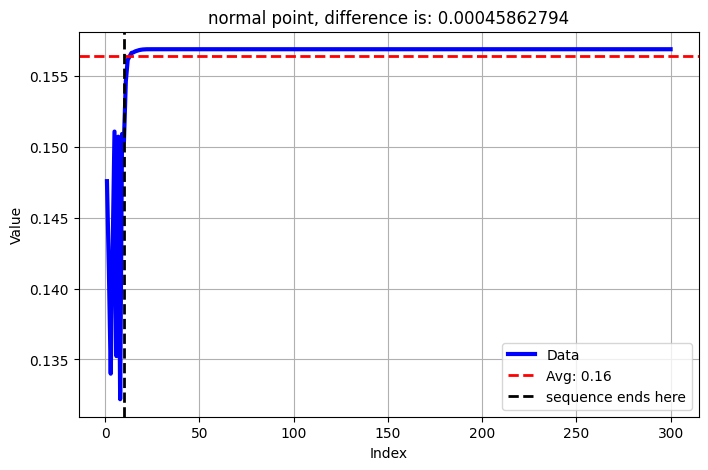

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


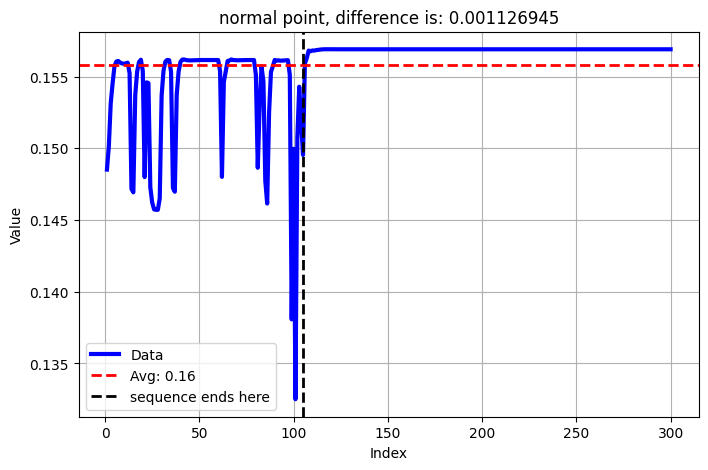

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


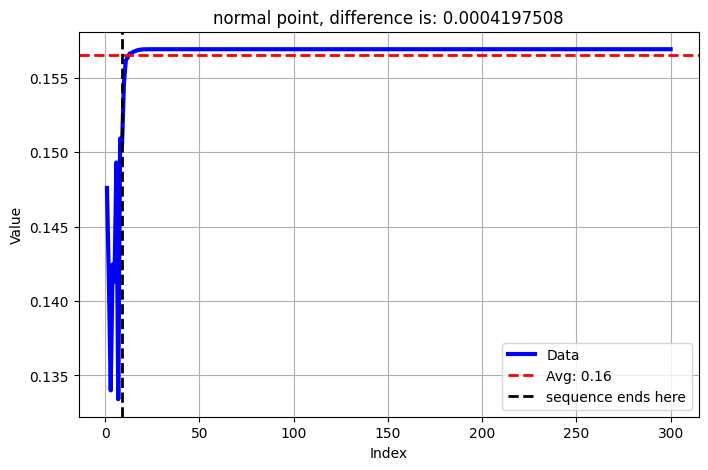

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


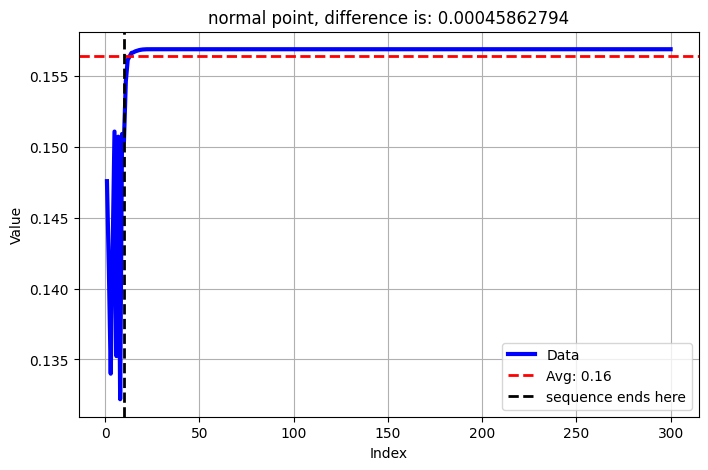

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


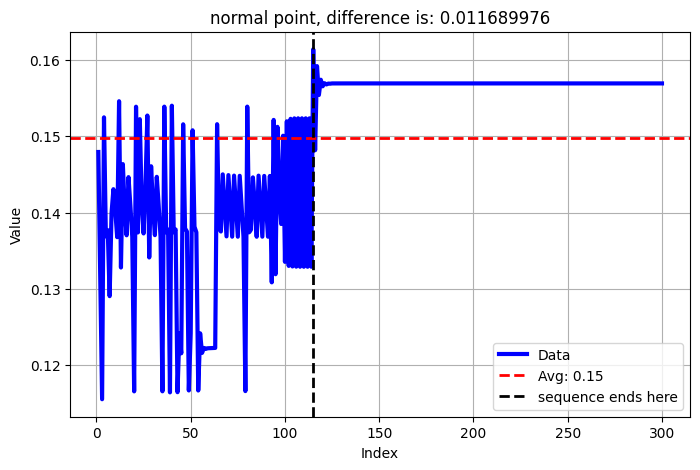

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


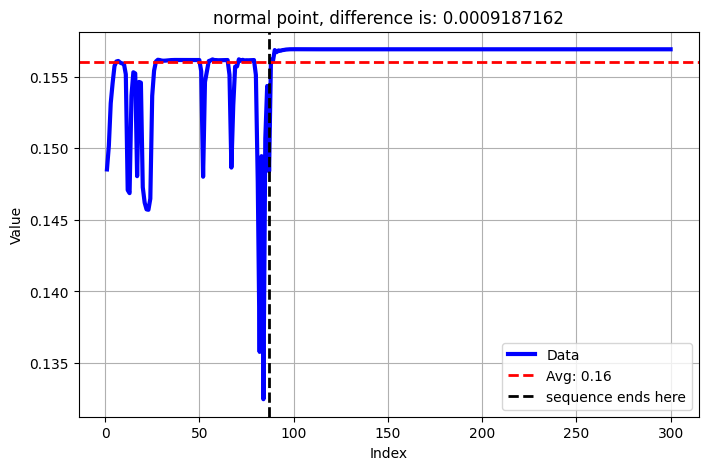

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


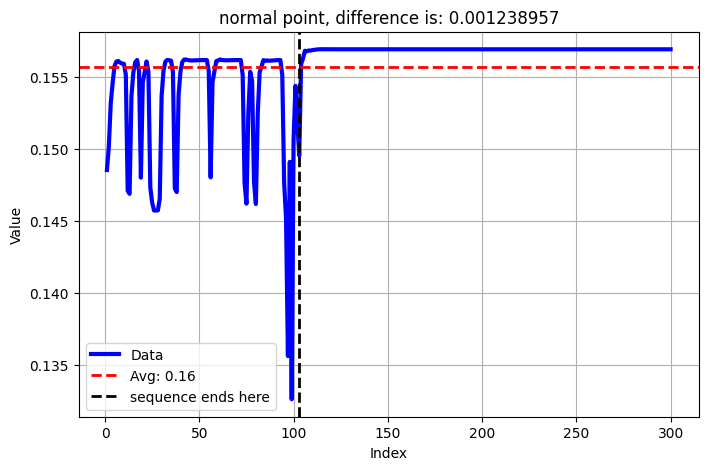

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


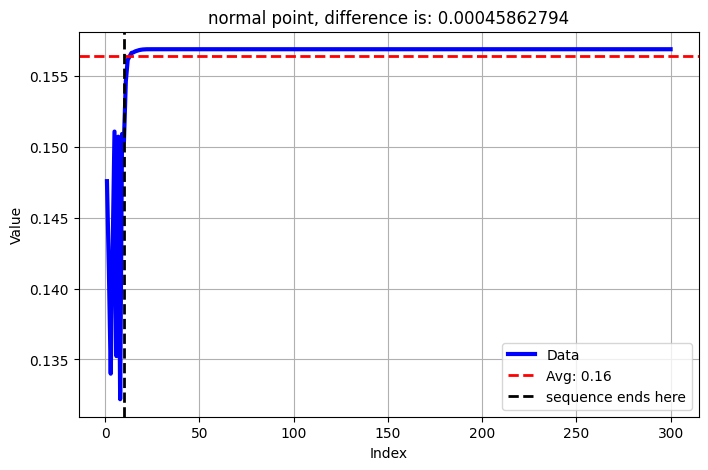

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


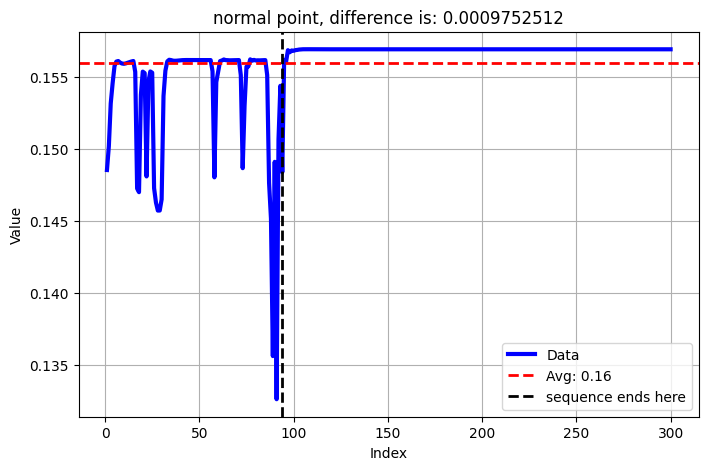

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


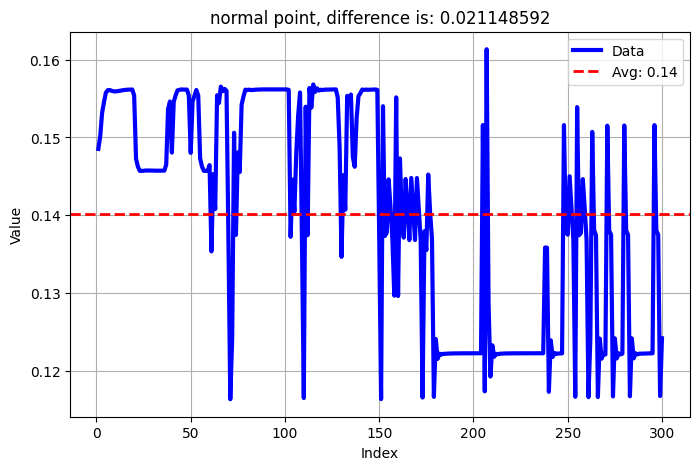

In [20]:
import matplotlib.pyplot as plt
def find_padding_start(arr):
    """
    Finds the index of the first row where padding starts in a numpy array.
    
    Args:
        arr (np.ndarray): A 2D numpy array with shape (50, 48), where padding may have occurred.
    
    Returns:
        int: The index of the first row where padding starts.
        None: If no padding is found.
    """
    for i in range(1, arr.shape[0]):
        if arr[i] == 474:  # Compare the current row with the previous one
            return i  # Return the index where padding starts
    
    return None  # Return None if no padding is detected

def plot_timedistributed_sequence(model, data_point, label):
    sample = np.expand_dims(data_point, axis=0)
    padding_starts_at = find_padding_start(data_point)
    result = model.predict(sample)
    result_reshaped = result.flatten()
    avg_value = np.mean(result)
    max_value = np.max(result)
    x_values = np.arange(1, 301)  # X-axis: Integers from 1 to 50

    # Create the plot
    plt.figure(figsize=(8, 5))
    plt.plot(x_values, result_reshaped, color='blue', linewidth=3, label="Data")
    plt.axhline(y=avg_value, color='red', linewidth=2, linestyle="--", label=f"Avg: {avg_value:.2f}")
    if padding_starts_at != None:
        plt.axvline(x = padding_starts_at+1, color='black', linewidth=2, linestyle = '--', label="sequence ends here")
    # Labels and title
    plt.xlabel("Index")
    plt.ylabel("Value")
    if label == 1:
        plt.title("anomaly point, difference is: " + str(max_value-avg_value))
    else:
        plt.title("normal point, difference is: " + str(max_value-avg_value))
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()
for i in range(20):
    plot_timedistributed_sequence(model, X_test[i], y_test[i])